# Regression 2

In [1]:
import functions

import os
import scipy.io
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# for clustering
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split

# for statistical tests
from scipy.stats import ttest_rel, ttest_ind
from statsmodels.stats.multitest import multipletests

In [2]:
import importlib
importlib.reload(functions)

<module 'functions' from '/Users/maylismuller/Desktop/EPFL_DOCS/Master/MA4/Project Hummel/uphummel_MA4/functions.py'>

## Loading the data

In [ ]:
excel_folder_path = "data/"
FM_folder_path = "data/Raw_MissingDataImputed/"
regression_info, rsfMRI_full_info = functions.load_excel_data(excel_folder_path, FM_folder_path)
folder_path = "FC_matrices_times_wp11/"

rois = [363, 364, 365, 368, 372, 373, 374, 377, 379, 361, 370, 362, 371, 12, 54, 56, 78, 96, 192, 234, 236, 258, 276, 8, 9, 51, 52, 53, 188, 189, 231, 232, 233]
rois = [roi - 1 for roi in rois]
rois_sub = rois
rois_full = np.arange(0, 379)
selected_rois = [362, 363, 364, 367, 371, 372, 373, 376]
striatum_labels = [
    'Caudate_ipsi', 'Putamen_ipsi', 'Caudate_contra', 'Putamen_contra', 'Pallidum_ipsi', 'Pallidum_contra', 
    'Accumbens_ipsi', 'Accumbens_contra'
]

striatum_labels = [
    'Caudate_ipsi', 'Putamen_ipsi', 'Caudate_contra', 'Putamen_contra', 'Pallidum_ipsi', 'Pallidum_contra', 
    'Accumbens_ipsi', 'Accumbens_contra'
]
all_matrices, all_subjects, yeo_mat_all_rois, roi_mapping_yeo = functions.load_matrices(folder_path, rsfMRI_full_info, rois, request_type='all', plot=False)
t1_t3_t4_matched = all_matrices.copy().dropna(subset=['T1_matrix', 'T3_matrix', 'T4_matrix'])

roi_mapping = functions.load_roi_labels("data/HCP-MMP1_RegionsCorticesList_379.csv")  # adapt path

Trying to load: TiMeS_matrix_mdImputed_allT4.xlsx
✅ Successfully loaded: TiMeS_matrix_mdImputed_allT4.xlsx
Trying to load: TiMeS_matrix_mdImputed_allT3.xlsx
✅ Successfully loaded: TiMeS_matrix_mdImputed_allT3.xlsx
Trying to load: TiMeS_matrix_mdImputed_allT2.xlsx
✅ Successfully loaded: TiMeS_matrix_mdImputed_allT2.xlsx
Trying to load: TiMeS_matrix_mdImputed_allT1.xlsx


✅ Successfully loaded: TiMeS_matrix_mdImputed_allT1.xlsx


In [ ]:
df_aligned, regression_info = functions.switch_contra_ipsi_df(
    t1_t3_t4_matched, 
    regression_info, 
    tp=3, 
    rois=rois, 
    roi_mapping=roi_mapping
)
df_L, df_R = functions.split_by_lesion_side(t1_t3_t4_matched)
print(f"{len(df_L)} left-lesioned subjects")
print(f"{len(df_R)} right-lesioned subjects")
df_aligned_L_T3 = functions.switch_contra_ipsi_df(
    df_L, 
    regression_info, 
    tp=3, 
    rois=rois, 
    roi_mapping=roi_mapping
)

df_aligned_R_T3 = functions.switch_contra_ipsi_df(
    df_R, 
    regression_info, 
    tp=3, 
    rois=rois, 
    roi_mapping=roi_mapping
)

df_aligned_L_T4 = functions.switch_contra_ipsi_df(
    df_L, 
    regression_info, 
    tp=4, 
    rois=rois, 
    roi_mapping=roi_mapping
)

df_aligned_R_T4 = functions.switch_contra_ipsi_df(
    df_R, 
    regression_info, 
    tp=4, 
    rois=rois, 
    roi_mapping=roi_mapping
)

8 left-lesioned subjects
17 right-lesioned subjects


In [ ]:
print(f"Number of subjects with T1, T3, and T4 matrices, and without undefined stroke lesion side: {len(df_aligned)}")
print("Number of predictors: ", len(rois-1)) # I drop Brainstem, as not defined as L or R

Number of subjects with T1, T3, and T4 matrices, and without undefined stroke lesion side: 25
Number of predictors:  33


In [ ]:
def keep_selected_rows(mat, selected_rois):
    if mat is None:
        return None
    return mat.loc[selected_rois, :]

t1_t3_t4_matched_sel = df_aligned.copy()

for col in ['T1_matrix', 'T3_matrix', 'T_matrix']:
    if col in df_aligned.columns:
        t1_t3_t4_matched_sel[col] = df_aligned[col].apply(lambda mat: keep_selected_rows(mat, striatum_labels))

selected_col = 'T1_matrix'
tp = 1

# Step 4: Merge with motor scores
regression_t = regression_info[
    (regression_info["TimePoint"] == f"T{tp}") &
    (regression_info["Behavioral_assessment"] == 1) &
    (regression_info["MRI"] == 1)
].copy()

valid_data = t1_t3_t4_matched_sel.merge(
        regression_t[["subject_id", "nmf_motor", "Fugl_Meyer_contra", "Fugl_Meyer_ipsi"]],
        on="subject_id"
    )

In [ ]:
print(f"Number of subjects with T1, T3, and T4 matrices, and without undefined stroke lesion side: {len(valid_data)}")

Number of subjects with T1, T3, and T4 matrices, and without undefined stroke lesion side: 25


In [ ]:
X = np.array([fc.values.flatten() for fc in valid_data[selected_col]]) 

# Example matrix from one subject
example_fc = valid_data[selected_col].iloc[0]  # shape (8, 33)

# Extract row and column labels
row_labels = example_fc.index.tolist()
col_labels = example_fc.columns.tolist()

# Create ROIxROI feature names
feature_names = [f"{row}|{col}" for row in row_labels for col in col_labels]

X_df = pd.DataFrame(X, columns=feature_names)  # No scaling
X_df_clean = X_df.dropna(axis=1) # Shape: (n_subjects=25, 8×32 - diagonal values that are nan = 248)

param_grid = {
    "rfe__n_features_to_select": [5, 10, 17, 18, 19, 20, 21, 22, 23, 24, 30, 40, 80, 160, X_df_clean.shape[1]]
}

In [ ]:
print("X_df_clean shape:", X_df_clean.shape)
print("Any NaNs?:", X_df_clean.isnull().values.any())
print("Max/Min/Std per feature:", X_df_clean.describe().T[['mean', 'std']])

X_df_clean shape: (25, 248)
Any NaNs?: False
Max/Min/Std per feature:                                                     mean       std
Caudate_ipsi|Putamen_ipsi                       0.206684  0.302451
Caudate_ipsi|Pallidum_ipsi                      0.095186  0.169559
Caudate_ipsi|Accumbens_ipsi                     0.014392  0.144203
Caudate_ipsi|Cerebellu_ipsi                     0.152811  0.178173
Caudate_ipsi|Thalamus_ipsi                      0.417588  0.301969
...                                                  ...       ...
Accumbens_contra|Primary_Motor_Cortex_contra   -0.031660  0.312794
Accumbens_contra|Primary_Sensory_Cortex_contra -0.080445  0.277180
Accumbens_contra|Area_1_contra                 -0.109857  0.309560
Accumbens_contra|Area_2_contra                 -0.120452  0.286974
Accumbens_contra|Area_3a_contra                -0.063959  0.270952

[248 rows x 2 columns]


NB: As there are 8 diagonal values, 8 columns will be full of empty data

## Ridge Regression

### Modeling Rationale: RFE, Ridge Regression, and R² Scoring

To predict motor behavior from functional connectivity (FC) features, we used a modeling pipeline combining **Recursive Feature Elimination (RFE)**, **Ridge Regression**, and **R² scoring**, selected based on the nature of our data and the goals of the analysis.

#### Why RFE?
**Recursive Feature Elimination (RFE)** is a wrapper-based feature selection method that iteratively removes the least informative features based on model performance. This is particularly important in neuroimaging datasets, where:

- The number of features (e.g., FC links) often exceeds the number of subjects.
- Many features are noisy or redundant.
- We seek interpretability: RFE helps identify a **compact, informative subset** of brain connections most predictive of motor outcomes.

#### Why Ridge Regression?
We used **Ridge regression** (ℓ2-regularized linear regression) because:

- It handles **high-dimensional data** well, where standard linear regression would overfit.
- It is robust to **multicollinearity**, which is common in brain connectivity data (many FC features are correlated).
- It regularizes coefficient estimates, improving model generalization without forcing sparsity (unlike Lasso).

#### Why R² Scoring?
We evaluated model performance using **R² (coefficient of determination)** because:

- It quantifies how much variance in the motor outcome is explained by the model.
- It is scale-invariant and interpretable: e.g., an R² of 0.6 means 60% of the variance is explained.
- It is standard in regression analysis and particularly useful for comparing predictive performance across models and feature sets.

---

Together, this pipeline provides a statistically sound, interpretable, and generalizable approach for linking FC features to behavioral outcomes.


### Fuegl-Meyer Ipsi

In [ ]:
y = valid_data['Fugl_Meyer_ipsi'].values

256
248


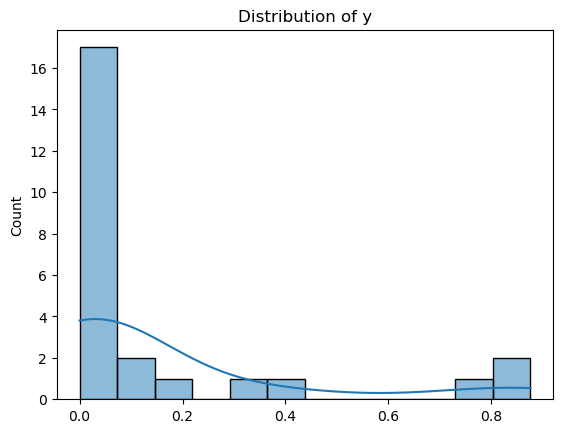

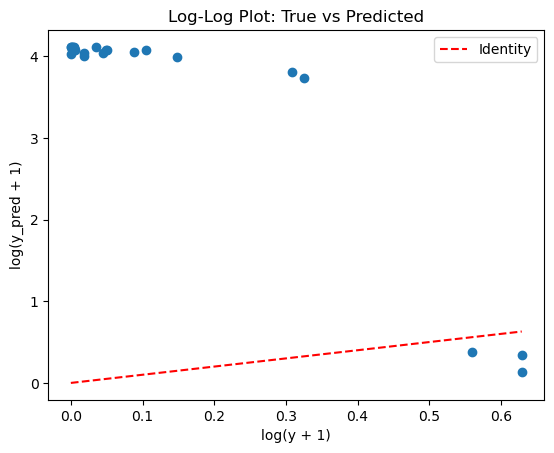

In [ ]:
import seaborn as sns
import numpy as np
sns.histplot(y, kde=True)
plt.title("Distribution of y")
plt.show()

# Log-log plot of y vs y_pred
import matplotlib.pyplot as plt

# Avoid log(0) by adding a small constant (or use log1p if values are >= 0)
y_log = np.log1p(y)
y_pred_log = np.log1p(y_pred)

plt.scatter(y_log, y_pred_log)
plt.xlabel("log(y + 1)")
plt.ylabel("log(y_pred + 1)")
plt.title("Log-Log Plot: True vs Predicted")
plt.plot([y_log.min(), y_log.max()], [y_log.min(), y_log.max()], 'r--', label='Identity')
plt.legend()
plt.show()

NB: Here, low sample (25) with high predictors (256), and y is skewed ! But not a Power law

In [ ]:
selected_feature_names, grid = functions.run_Ridge_with_RFE(X_df_clean, y, param_grid)

/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/feature_selection/_rfe.py:291: UserWarning: Found n_features_to_select=256 > n_features=248. There will be no feature selection and all features will be kept.
  warnings.warn(
/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/feature_selection/_rfe.py:291: UserWarning: Found n_features_to_select=256 > n_features=248. There will be no feature selection and all features will be kept.
  warnings.warn(
/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/feature_selection/_rfe.py:291: UserWarning: Found n_features_to_select=256 > n_features=248. There will be no feature selection and all features will be kept.
  warnings.warn(
/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/feature_selection/_rfe.py:291: UserWarning: Found n_features_to_select=256 > n_features=248. There will be no feature selection and all features will be

Best number of features: 22
Best cross-validated R² score: -3.089460958470701
Selected feature names: ['Caudate_ipsi|Cerebellu_ipsi', 'Caudate_ipsi|Area_6_anterior_contra', 'Caudate_ipsi|Area_1_contra', 'Caudate_ipsi|Area_2_contra', 'Putamen_ipsi|Cerebellu_ipsi', 'Putamen_ipsi|Rostral_Area_6_ipsi', 'Putamen_ipsi|Thalamus_contra', 'Caudate_contra|Putamen_ipsi', 'Caudate_contra|Cerebellu_ipsi', 'Caudate_contra|Area_55b_ipsi', 'Caudate_contra|Area_6_anterior_contra', 'Caudate_contra|Area_1_contra', 'Caudate_contra|Area_3a_contra', 'Pallidum_ipsi|Pallidum_contra', 'Pallidum_ipsi|Primary_Motor_Cortex_contra', 'Pallidum_ipsi|Area_1_contra', 'Pallidum_ipsi|Area_2_contra', 'Pallidum_ipsi|Area_3a_contra', 'Pallidum_contra|Dorsal_area_6_ipsi', 'Pallidum_contra|Rostral_Area_6_ipsi', 'Accumbens_ipsi|Cerebellu_contra', 'Accumbens_contra|Area_2_contra']
Top predictive features:
                                  Feature    Weight
8           Caudate_contra|Cerebellu_ipsi -0.395529
12          Caudate

R² on full data: 0.998
Mean Squared Error: 0.008
Mean Absolute Error: 0.073


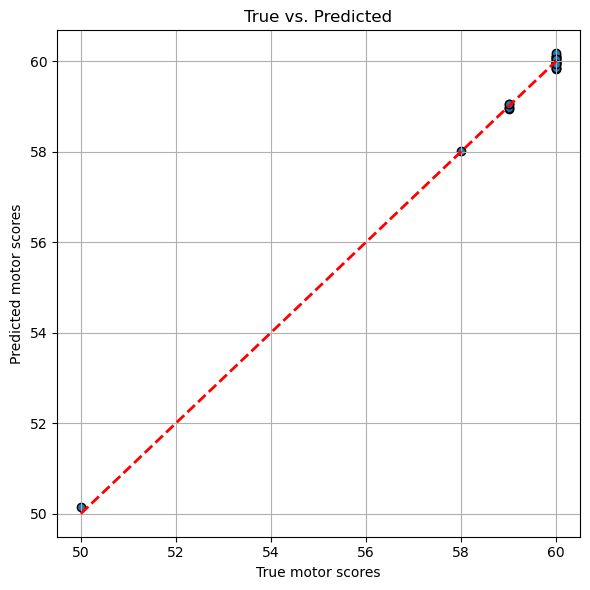

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Step 1: Predict with the best model on all data
y_pred = grid.best_estimator_.predict(X_df_clean)

# Step 2: Evaluate performance
r2 = r2_score(y, y_pred)
mse = mean_squared_error(y, y_pred)
mae = mean_absolute_error(y, y_pred)

print(f"R² on full data: {r2:.3f}")
print(f"Mean Squared Error: {mse:.3f}")
print(f"Mean Absolute Error: {mae:.3f}")

plt.figure(figsize=(6, 6))
plt.scatter(y, y_pred, edgecolor='k')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
plt.xlabel("True motor scores")
plt.ylabel("Predicted motor scores")
plt.title("True vs. Predicted")
plt.grid(True)
plt.tight_layout()
plt.show()


SEVERE OVERFITTING

### Fugl-Meyer Contra

In [ ]:
y = valid_data['Fugl_Meyer_contra'].values
selected_feature_names, grid = functions.run_Ridge_with_RFE(X_df_clean, y, param_grid)

/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/feature_selection/_rfe.py:291: UserWarning: Found n_features_to_select=256 > n_features=248. There will be no feature selection and all features will be kept.
  warnings.warn(
/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/feature_selection/_rfe.py:291: UserWarning: Found n_features_to_select=256 > n_features=248. There will be no feature selection and all features will be kept.
  warnings.warn(
/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/feature_selection/_rfe.py:291: UserWarning: Found n_features_to_select=256 > n_features=248. There will be no feature selection and all features will be kept.
  warnings.warn(
/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/feature_selection/_rfe.py:291: UserWarning: Found n_features_to_select=256 > n_features=248. There will be no feature selection and all features will be

Best number of features: 256
Best cross-validated R² score: -50.863391733698336
Selected feature names: ['Caudate_ipsi|Putamen_ipsi', 'Caudate_ipsi|Pallidum_ipsi', 'Caudate_ipsi|Accumbens_ipsi', 'Caudate_ipsi|Cerebellu_ipsi', 'Caudate_ipsi|Thalamus_ipsi', 'Caudate_ipsi|Area_55b_ipsi', 'Caudate_ipsi|Dorsal_area_6_ipsi', 'Caudate_ipsi|Ventral_Area_6_ipsi', 'Caudate_ipsi|Rostral_Area_6_ipsi', 'Caudate_ipsi|Area_6_anterior_ipsi', 'Caudate_ipsi|Primary_Motor_Cortex_ipsi', 'Caudate_ipsi|Primary_Sensory_Cortex_ipsi', 'Caudate_ipsi|Area_1_ipsi', 'Caudate_ipsi|Area_2_ipsi', 'Caudate_ipsi|Area_3a_ipsi', 'Caudate_ipsi|Caudate_contra', 'Caudate_ipsi|Putamen_contra', 'Caudate_ipsi|Pallidum_contra', 'Caudate_ipsi|Accumbens_contra', 'Caudate_ipsi|Cerebellu_contra', 'Caudate_ipsi|Thalamus_contra', 'Caudate_ipsi|Area_55b_contra', 'Caudate_ipsi|Dorsal_area_6_contra', 'Caudate_ipsi|Ventral_Area_6_contra', 'Caudate_ipsi|Rostral_Area_6_contra', 'Caudate_ipsi|Area_6_anterior_contra', 'Caudate_ipsi|Primary_M

R² on full data: 1.000
Mean Squared Error: 0.025
Mean Absolute Error: 0.108


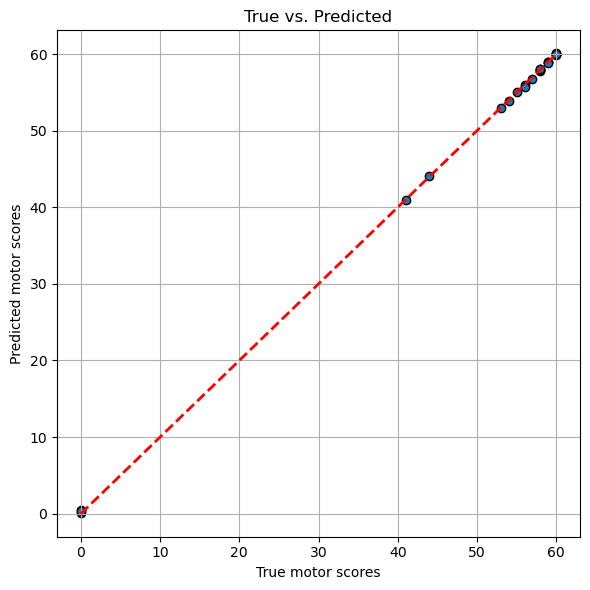

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Step 1: Predict with the best model on all data
y_pred = grid.best_estimator_.predict(X_df_clean)

# Step 2: Evaluate performance
r2 = r2_score(y, y_pred)
mse = mean_squared_error(y, y_pred)
mae = mean_absolute_error(y, y_pred)

print(f"R² on full data: {r2:.3f}")
print(f"Mean Squared Error: {mse:.3f}")
print(f"Mean Absolute Error: {mae:.3f}")

plt.figure(figsize=(6, 6))
plt.scatter(y, y_pred, edgecolor='k')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
plt.xlabel("True motor scores")
plt.ylabel("Predicted motor scores")
plt.title("True vs. Predicted")
plt.grid(True)
plt.tight_layout()
plt.show()


### nmf motor

In [ ]:
y = valid_data['nmf_motor'].values
selected_feature_names, grid = functions.run_Ridge_with_RFE(X_df_clean, y, param_grid)

/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/feature_selection/_rfe.py:291: UserWarning: Found n_features_to_select=256 > n_features=248. There will be no feature selection and all features will be kept.
  warnings.warn(
/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/feature_selection/_rfe.py:291: UserWarning: Found n_features_to_select=256 > n_features=248. There will be no feature selection and all features will be kept.
  warnings.warn(
/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/feature_selection/_rfe.py:291: UserWarning: Found n_features_to_select=256 > n_features=248. There will be no feature selection and all features will be kept.
  warnings.warn(
/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/feature_selection/_rfe.py:291: UserWarning: Found n_features_to_select=256 > n_features=248. There will be no feature selection and all features will be

Best number of features: 256
Best cross-validated R² score: -545.530818675318
Selected feature names: ['Caudate_ipsi|Putamen_ipsi', 'Caudate_ipsi|Pallidum_ipsi', 'Caudate_ipsi|Accumbens_ipsi', 'Caudate_ipsi|Cerebellu_ipsi', 'Caudate_ipsi|Thalamus_ipsi', 'Caudate_ipsi|Area_55b_ipsi', 'Caudate_ipsi|Dorsal_area_6_ipsi', 'Caudate_ipsi|Ventral_Area_6_ipsi', 'Caudate_ipsi|Rostral_Area_6_ipsi', 'Caudate_ipsi|Area_6_anterior_ipsi', 'Caudate_ipsi|Primary_Motor_Cortex_ipsi', 'Caudate_ipsi|Primary_Sensory_Cortex_ipsi', 'Caudate_ipsi|Area_1_ipsi', 'Caudate_ipsi|Area_2_ipsi', 'Caudate_ipsi|Area_3a_ipsi', 'Caudate_ipsi|Caudate_contra', 'Caudate_ipsi|Putamen_contra', 'Caudate_ipsi|Pallidum_contra', 'Caudate_ipsi|Accumbens_contra', 'Caudate_ipsi|Cerebellu_contra', 'Caudate_ipsi|Thalamus_contra', 'Caudate_ipsi|Area_55b_contra', 'Caudate_ipsi|Dorsal_area_6_contra', 'Caudate_ipsi|Ventral_Area_6_contra', 'Caudate_ipsi|Rostral_Area_6_contra', 'Caudate_ipsi|Area_6_anterior_contra', 'Caudate_ipsi|Primary_Mot

/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/feature_selection/_rfe.py:291: UserWarning: Found n_features_to_select=256 > n_features=248. There will be no feature selection and all features will be kept.
  warnings.warn(
